In [1]:
rm(list=ls())

In [2]:
# Phenotypic space; R refers to the resistance level and varies from the minimum value of 2 to 10000 (ug/ml)
R=seq(1,10000, 10) 
States=seq(1, length(R));

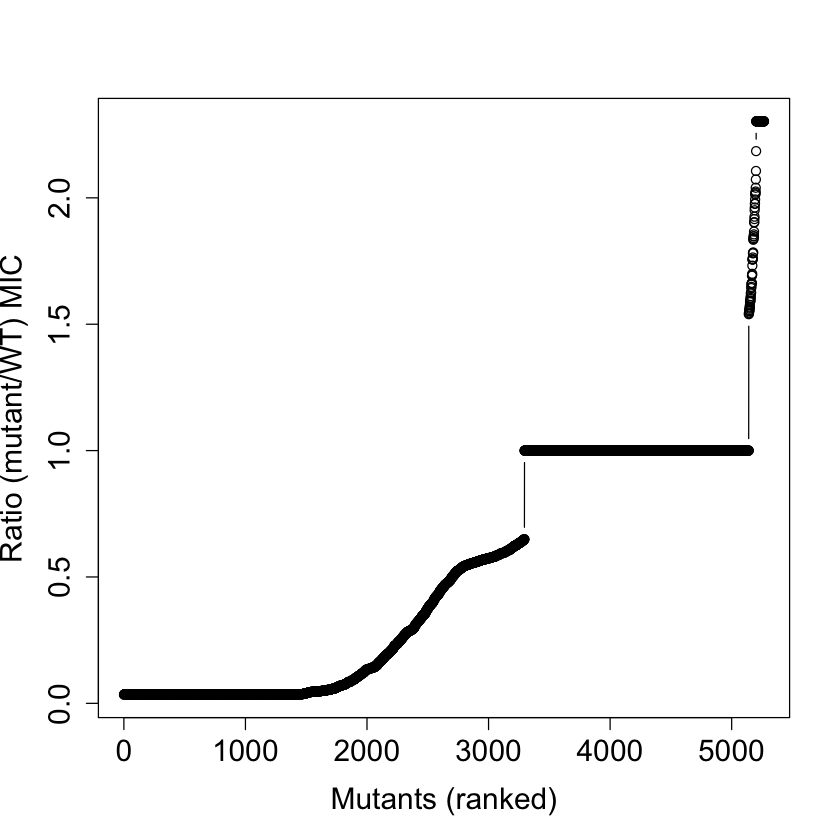

In [8]:
DME=readRDS(file = "DME.RDS")
plot(sort(DME), xlab="Mutants (ranked)", ylab="Ratio (mutant/WT) MIC", cex.lab=1.5, cex.axis=1.5, type="b")

In [9]:
drift_MIC=function(X_WT, DME, R){
    
MIC_WT=X_WT
new_MIC=MIC_WT*DME
R_cap=rep(0, length(R))
    
for (i in 1:length(new_MIC)){
    index=which.min(abs(new_MIC[i] - R)) 
    R_cap[index]=R_cap[index] +1
}  
    P_drift=R_cap/length(new_MIC)
    return(P_drift)    
}

In [10]:
# Defining the transition probability matrix

P=matrix(0, nrow = length(States), ncol = length(States))

# The concentration of Ampicillin in experimenst and simulations
AMP=10 ## Ampicillin Concentration

# Relating resistance levels to fitness
X50=0.93*AMP-1.29

# Population size
N=1e4

for (i in 1:length(P[,1])){  # We fill by rows
    
X_WT=R[i] # Resistance level of WT
X_mut=R   # Resistance level of mutants
      
# Fitness equation is coming from previous experiments by John Chen and colleagues in Tokuriki Lab
Fitness_WT=  1/(1+(X50/X_WT)^5)
Fitness_mut= 1/(1+(X50/X_mut)^5) 
Fitness_mut[which(is.na(Fitness_mut))]=-4   
 
# Selection coefficient
s= Fitness_mut - Fitness_WT
 
#s=log(Fitness_mut/Fitness_WT)
# Probability of fixation for haploid populations; Kimura's Formula
Pfix=(1-exp(-2*s))/(1-exp(-2*s*N)) 

# Accounting for singularity when s=0; Strictly neutral mutations
Pfix[which(s==0)]=1/N

# The drift component of transition probability
Pdrift=drift_MIC(X_WT, DME, X_mut)

# The transition probability in our Markov Chain simulations is equal to the product of a drift component 
# and a selection component.
    
P[i,]=Pfix*Pdrift
P[i,]=P[i,]/sum(P[i,])
    
}

In [11]:
# The core of Markov chains simulstions
# Here, we simulate discrete Markov chains according to transition matrix P

run.mc.sim <- function(P, num.iters, init_state) {
  
  # number of possible states
  num.states <- nrow(P)
  
  # stores the states X_t through time
  states     <- numeric(num.iters)

  # initialize variable for first state 
  states[1]    <- init_state

  for(t in 2:num.iters) {
    
    # probability vector to simulate next state X_{t+1}
    p  <- P[states[t-1], ]
    
    ## draw from multinomial and determine state
    states[t] <-  which(rmultinom(1, 1, p) == 1)
  }
  return(states)
}

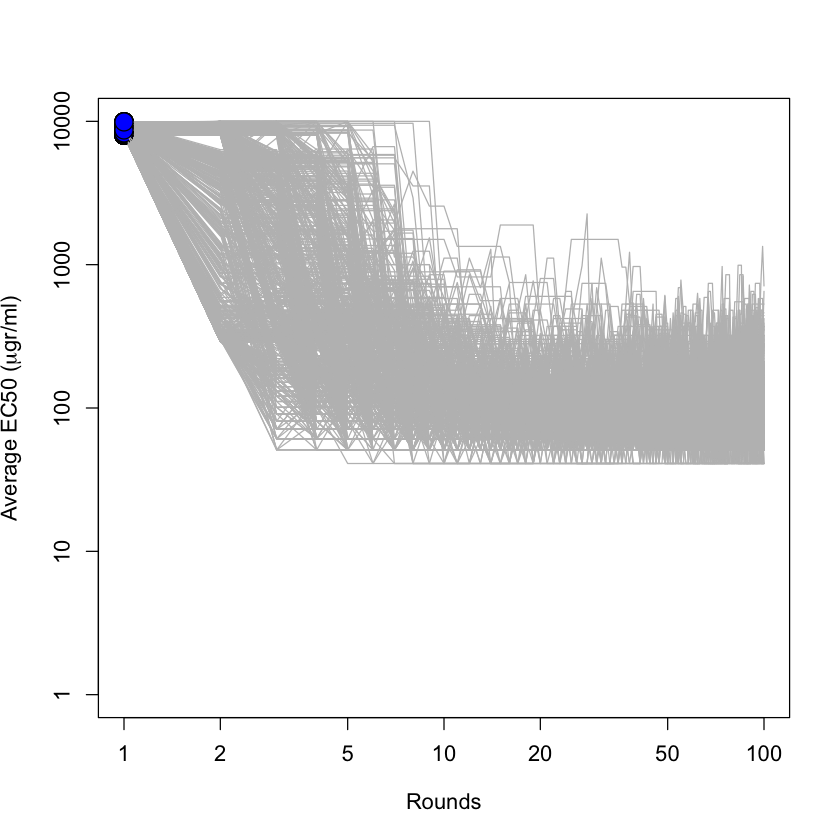

In [12]:

n_variants=1000
R_init=seq(8000,10000, 100)
dF_dEC50_matrix=vector()


dF_mat=matrix(NA, nrow = n_variants, ncol = 99)

dEC50_matrix_fold=matrix(NA, nrow = n_variants, ncol = 99)
dEC50_mat=matrix(NA, nrow = n_variants, ncol = 99)

EC50_matrix=matrix(NA, nrow = 100, ncol = n_variants)
fish=0
#pdf("./For_Ayse_SvgFormat/November_4th/point_5_T10_different_initial_EC50s.pdf")
for (i in 1:n_variants){

# Initial_point_1
init_EC50=sample(R_init, 1)

# Here, we make sure the initial resistance value is not
# higher than our maximum resistance in the phenotype space
check_init=length(which(R>init_EC50))

if (check_init > 0) {
    
# We determine the phenotypic state that corresponds to the initial resistance level
init_state=which(R>init_EC50)[1]-1

    
# Number of Markov Chains (and not states!): These corresponds to different proteins
# that can evolve (or transition) from their state to other states    
num.chains     <- 1
    
# Number of iterations that we advance our Markov chains
# This corresponds to the rounds of evolution
num.iterations <- 100

chain.states <- matrix(NA, ncol=num.chains, nrow=num.iterations)
for(c in seq_len(num.chains)){
  chain.states[,c] <- run.mc.sim(P, num.iters = num.iterations, init_state = init_state)
}


if (i==1){
    plot(R[chain.states], type="l", log="xy", ylim=c(1,10000),
        cex.lab=1.1, col="gray", cex.axis=1.1, xlab="Rounds",ylab=expression(paste("Average EC50 (", mu,"gr/ml)", sep="")) )
    lines(init_EC50, cex=2, type="p", pch=21, bg="blue")
} else {
    lines(R[chain.states], col="gray")
    lines(init_EC50, cex=2,  type="p", pch=21, bg="blue")
}
 
    
    
}
    
        
}
